In [10]:
!pip install roboflow

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import cv2
import xml.etree.ElementTree as ET

2024-12-01 02:56:41.068304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 02:56:41.122761: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 02:56:41.124053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 02:56:41.961668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Concatenate()([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.Concatenate()([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [6]:
def parse_voc_xml(xml_file, img_size=(128, 128)):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    mask = np.zeros((img_size[0], img_size[1]), dtype=np.uint8)

    for obj in root.findall('object'):
        polygon = []

        bndbox = obj.find('bndbox')
        if bndbox is not None:
            x_min = int(bndbox.find('xmin').text)
            y_min = int(bndbox.find('ymin').text)
            x_max = int(bndbox.find('xmax').text)
            y_max = int(bndbox.find('ymax').text)

            polygon = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])

            polygon = polygon.reshape((-1, 1, 2))

            cv2.fillPoly(mask, [polygon], color=1)

    return mask

In [7]:
def load_data(data_dir, img_size=(128, 128)):
    images = []
    masks = []

    for file_name in os.listdir(data_dir):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(data_dir, file_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)

            xml_file_name = file_name.replace('.jpg', '.xml')
            xml_path = os.path.join(data_dir, xml_file_name)
            mask = parse_voc_xml(xml_path, img_size)
            mask = np.expand_dims(mask, axis=-1)
            masks.append(mask)

    images = np.array(images) / 255.0
    masks = np.array(masks)
    return images, masks

In [18]:
data_dir = 'IdeaProjects/green_area'


In [19]:
x_train, y_train = load_data(data_dir)
val_images, val_masks = load_data("IdeaProjects/green_area'/valid")
x_test, y_test = load_data("IdeaProjects/green_area'/test")

input_shape = (128, 128, 3)
model = unet(input_shape)

FileNotFoundError: [Errno 2] No such file or directory: 'IdeaProjects/green_area'

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 10
epochs = 50

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs)

model.save('unet_model_green_area.keras')

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 738ms/step - accuracy: 0.5491 - loss: 0.6903
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.5710 - loss: 0.6818
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5601 - loss: 0.6813
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5620 - loss: 0.6755
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5704 - loss: 0.6728
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6118 - loss: 0.6673
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6205 - loss: 0.6557
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6549 - loss: 0.6361
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6458 - loss: 0.6307
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6684 - loss: 0.6080
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6169 - loss: 0.6454
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/ste

In [ ]:
val_loss, val_accuracy = model.evaluate(val_images, val_masks)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6789 - loss: 0.6104
Validation Loss: 0.6104, Validation Accuracy: 0.6789
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7518 - loss: 0.5565
Test Loss: 0.5565, Test Accuracy: 0.7518


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


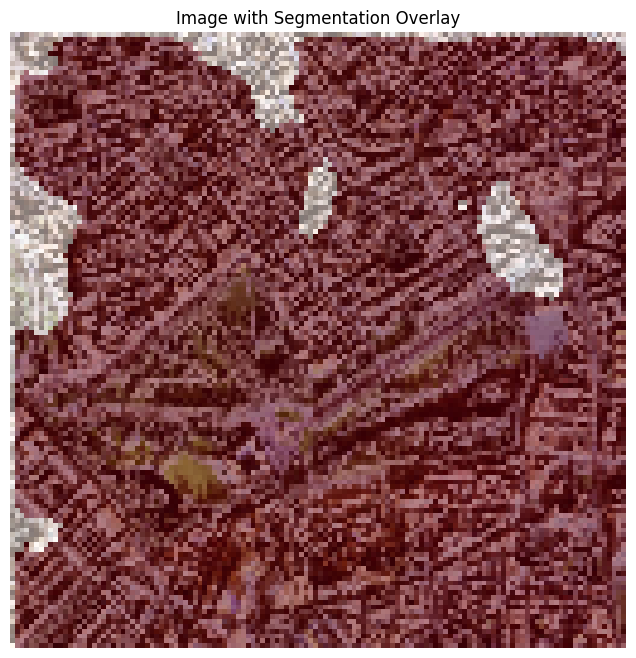

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


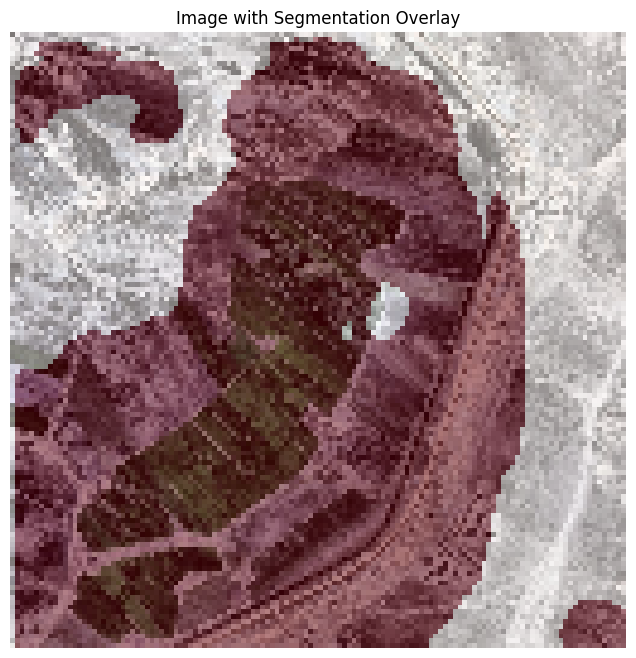

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


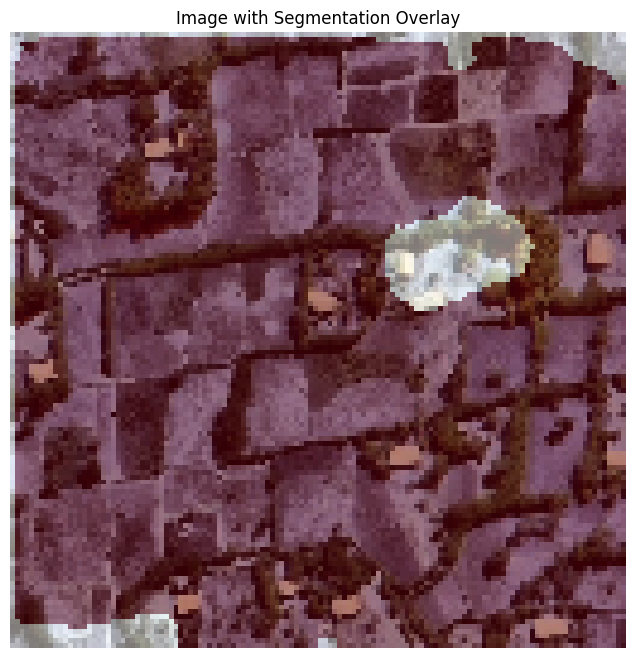

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segmentation_overlay(model, test_images, num_samples=5, alpha=0.5):
    for i in range(num_samples):
        img = test_images[i]

        predicted_mask = model.predict(img[np.newaxis, ...])[0]

        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        if predicted_mask.shape[:2] != img.shape[:2]:
            predicted_mask = np.squeeze(np.resize(predicted_mask, img.shape[:2]))

        # Overlay the mask on the image
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.imshow(predicted_mask, cmap='Reds', alpha=alpha)  # 'Reds' colormap for mask
        plt.title("Image with Segmentation Overlay")
        plt.axis("off")

        plt.show()

# Example usage (assuming you have test_images ready)
plot_segmentation_overlay(model, x_test, num_samples=3)
